In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

DEBUG=True

Using matplotlib backend: MacOSX


In [2]:
# 加载训练集与测试集。观察数据发现：Age(80.13%), Embarked(99.78%), Cabin(22.90%)数据缺失。Cabin数据缺失十分严重，暂不使用。
if DEBUG:
    train_df = pd.read_csv('https://query.data.world/s/j3odqqpvfgzd6aumavnijpu732udns') 
    test_df = pd.read_csv('https://query.data.world/s/nsjnqm7zljoejmszyab3hd67oycumq')
else:    
    train_df = pd.read_csv('../input/titanic/train.csv')
    test_df = pd.read_csv('../input/titanic/test.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 数据分布与特征

数据字段
- PassengerId: 乘客Id
- Pclass: 阶层。枚举值: 1st=Upper、2nd=Middle、3rd=Lower
- Name: 姓名    
- Sex: 性别。枚举值: male(男)，female(女)
- Age: 年龄
- SibSp: 该乘客一起旅行的兄弟姐妹和配偶的数量(同代直系亲属人数)。枚举值：daughter, son, stepdaughter, stepson
- Parch: 该和乘客一起旅行的父母和孩子的数量(不同代直系亲属人数)。枚举值：mother, father
- Ticket: 船票号
- Fare: 船票价
- Cabin: 船舱号
- Embarked: 登船港口。S=英国南安普顿Southampton(起航点)，C=法国 瑟堡市Cherbourg(途经点)，Q=爱尔兰 昆士敦Queenstown(途经点)

数据质量
- 数据缺失情况：Cabin(22.90%),Age(80.13%),Embarked(99.78%)

### 数据分布情况

--------------------- info ---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

--------------------- describe ---------------------
                    Name   Sex  Ticket Cabin Embarked
count                891   891     891   204      889
unique               891     2     681   147        3
top     Nakid, Mr. Sahid  male  347082    G6        S
freq                   1   577       7     4      644
       PassengerId    Survived      P

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11267c320>,
      dtype=object)

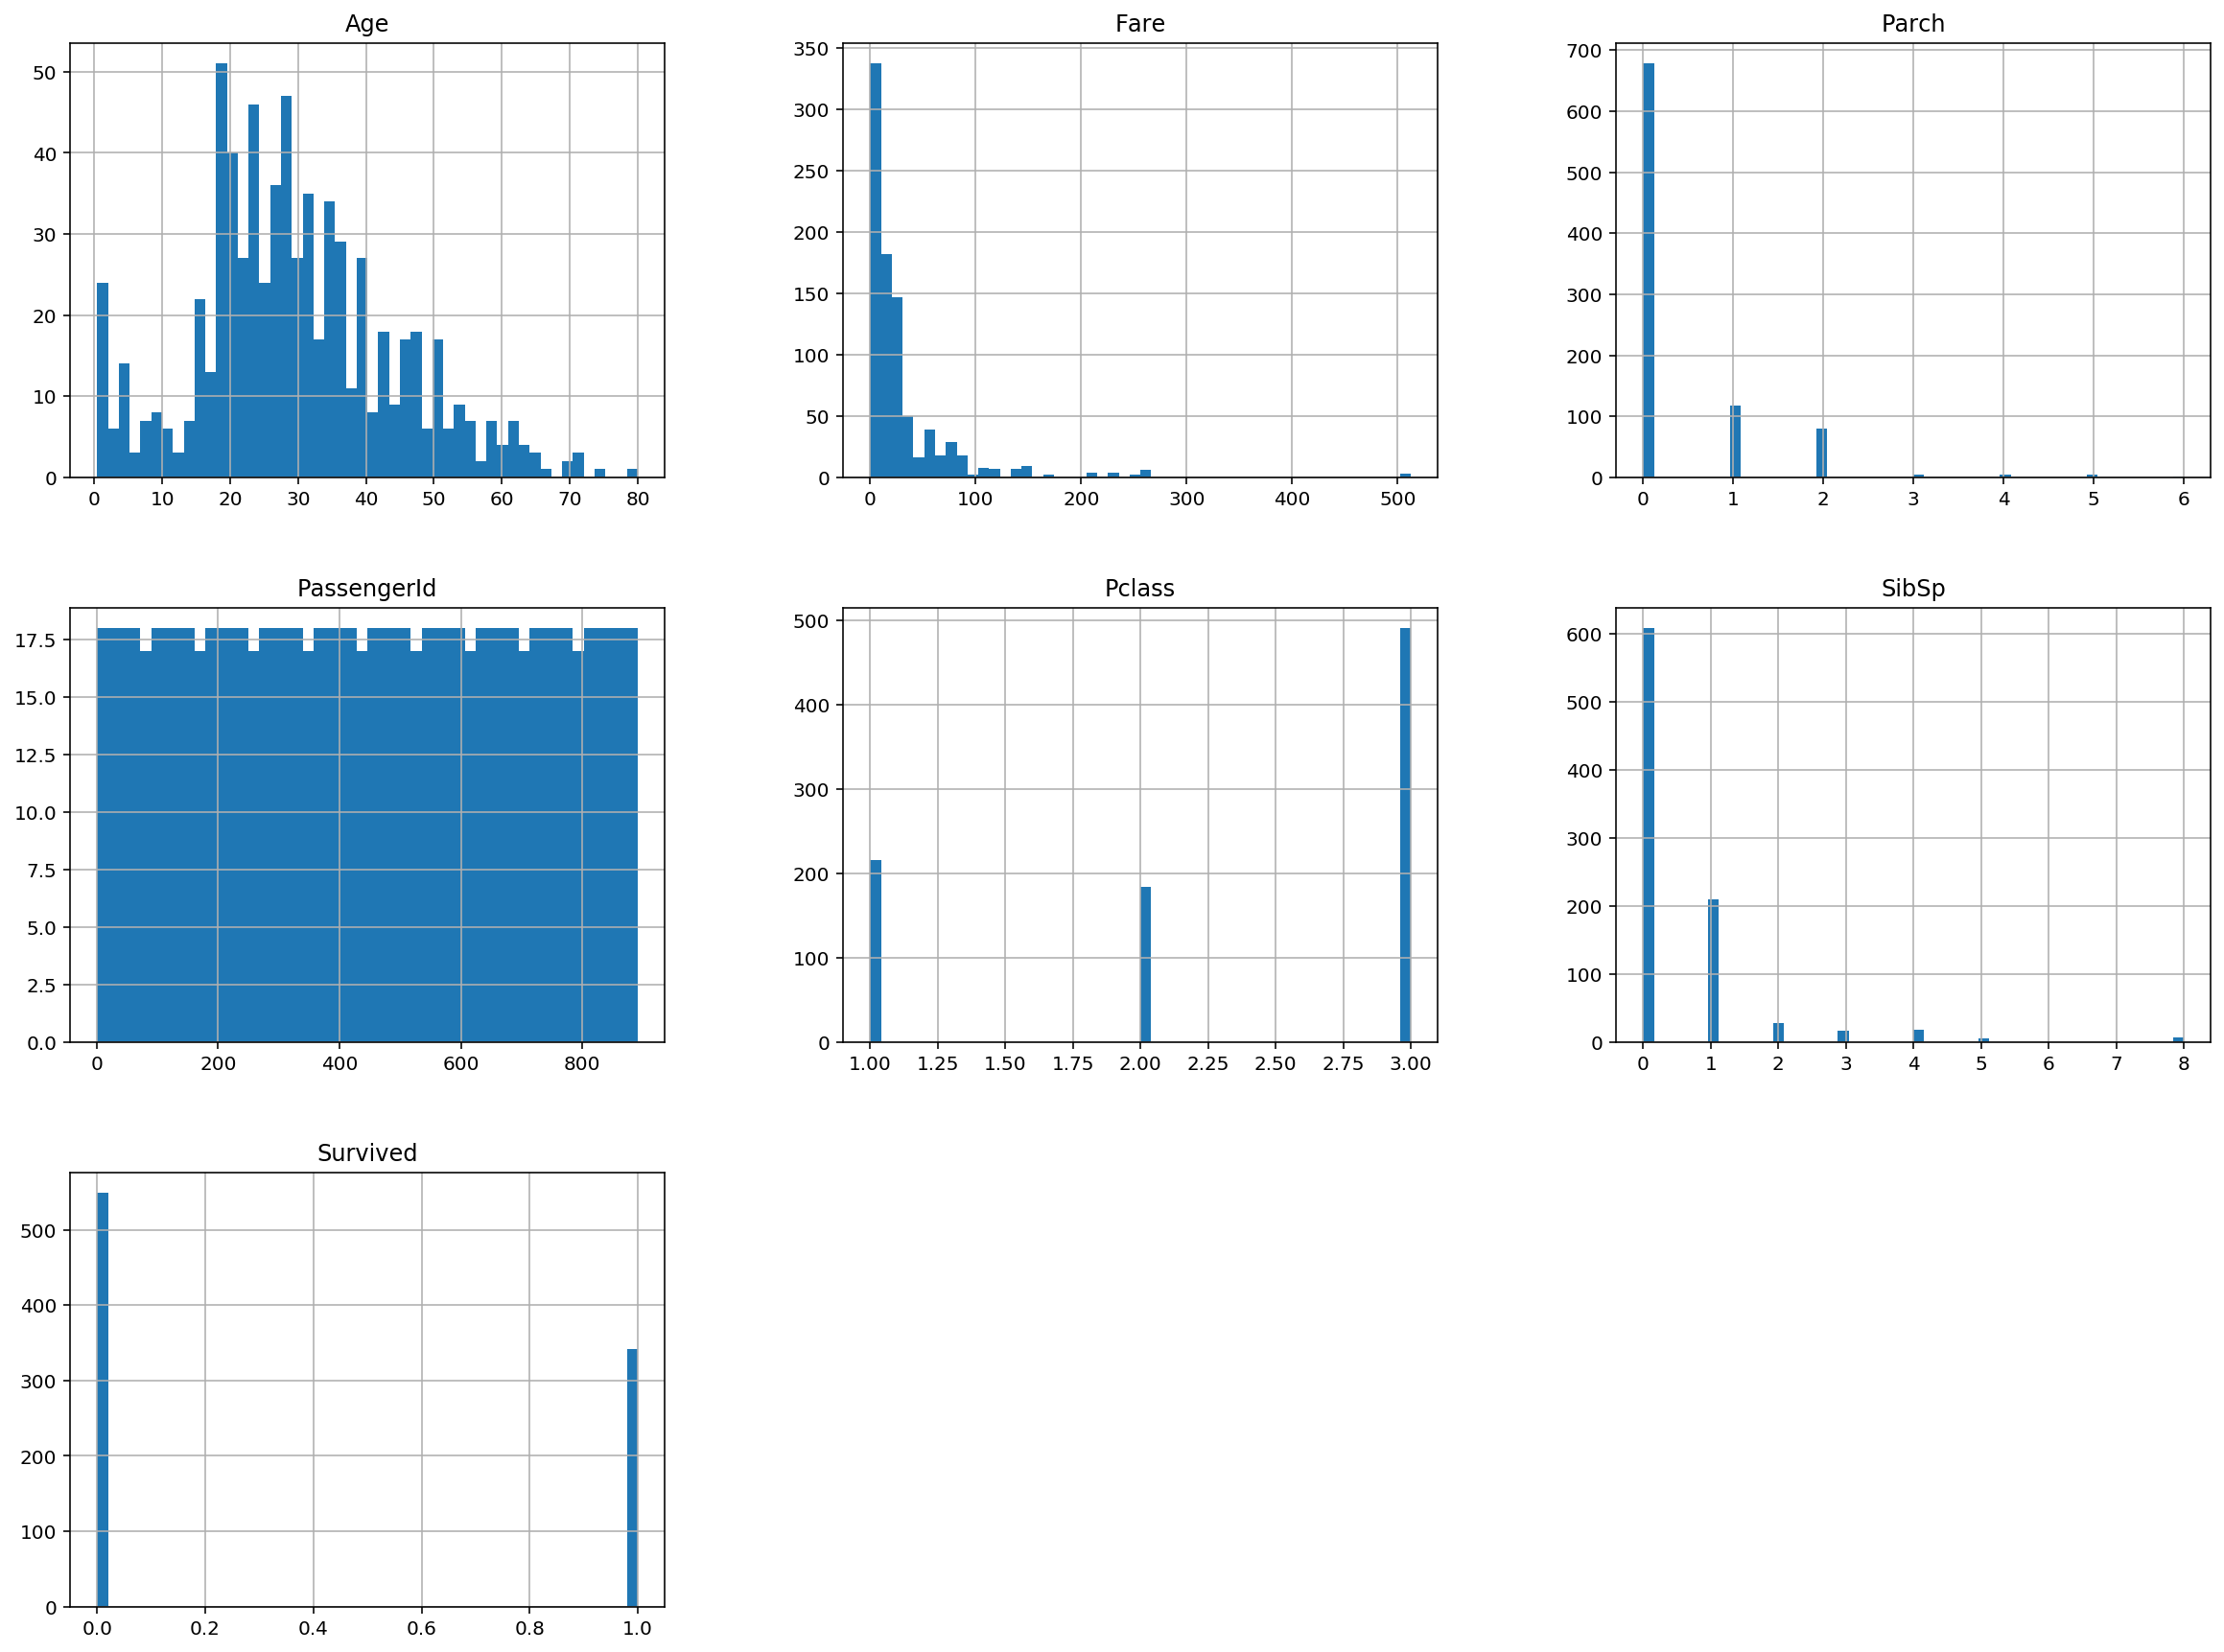

In [3]:
print('--------------------- info ---------------------')
print(train_df.info())
print('\n--------------------- describe ---------------------')
print(train_df.describe(include=['O']))
print(train_df.describe())
print('\n--------------------- Virtual ---------------------')
train_df.hist(bins=50, figsize=(20,15))

In [4]:
train_df.corr(method='pearson').sort_values(by='Survived')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307


## 数据预处理与特征工程

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    """
    sklearn库主要使用numpy数组, 所以将dataframe全部转化为numpy数组.
    自定义转化器需添加基类：BaseEstimator, TransformerMixin
    """
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        """返回numpy数组"""
        return x[self.attribute_names].values
    
def get_columns_index(df, columns):
    return [list(df.columns).index(column) for column in list(columns)]

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


# 数值类型处理
num_attribute_names = ['Pclass', 'Age','SibSp','Parch','Fare']

num_pipline = Pipeline([
    ('selector', DataFrameSelector(num_attribute_names)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# 文本类型处理
text_attribute_names = ['Sex','Ticket','Embarked']
text_pipline = Pipeline([
    ('selector', DataFrameSelector(text_attribute_names)),
    ('imputer', SimpleImputer(strategy='most_frequent')),    
    ('text_encoder', OneHotEncoder(sparse=False))
])

# 合并
union_pipplines = FeatureUnion(transformer_list=[
    ('num_pipline', num_pipline),
    ('text_pipline', text_pipline),
])

# 数据预处理
# TODO: OneHot编码，test数据集里的枚举值合并到测试集里，不然会报错。找到其他解决方案
union_pipplines.fit_transform(train_df.append(test_df))
train_df_prepares = union_pipplines.transform(train_df)
test_df_prepares = union_pipplines.transform(test_df)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


## 使用决策树模型

In [7]:
from sklearn.linear_model import Perceptron  # 80%
from sklearn.linear_model import LogisticRegression  # 80%
from sklearn.tree import DecisionTreeRegressor #  16%
from sklearn.ensemble import RandomForestRegressor # 44%
from sklearn.neighbors import KNeighborsClassifier # 80%

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

estimator = LogisticRegression()
estimator = GridSearchCV(estimator, param_grid={}, cv=5)
estimator.fit(train_df_prepares, train_df['Survived'])

test_df_predict = estimator.predict(test_df_prepares)

# 最佳参数
print(u'最佳参数: \n', estimator.best_params_)
# 最佳结果
print(u'结果: \n', estimator.best_score_)
# 最佳估计器
print(u'估计器: \n', estimator.best_estimator_)
# 交叉验证结果
print(u'交叉验证结果: \n', estimator.cv_results_)

最佳参数: 
 {}
结果: 
 0.8035904839620865
估计器: 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
交叉验证结果: 
 {'mean_fit_time': array([0.03599296]), 'std_fit_time': array([0.00736419]), 'mean_score_time': array([0.00078974]), 'std_score_time': array([0.0002548]), 'params': [{}], 'split0_test_score': array([0.80446927]), 'split1_test_score': array([0.79213483]), 'split2_test_score': array([0.79775281]), 'split3_test_score': array([0.79213483]), 'split4_test_score': array([0.83146067]), 'mean_test_score': array([0.80359048]), 'std_test_score': array([0.01465648]), 'rank_test_score': array([1], dtype=int32)}


In [8]:
test_df_tmp = test_df.copy()
test_df_tmp['Survived'] = test_df_predict
test_df_tmp[['PassengerId','Survived']].to_csv('result_2020030701.csv', index=False)
test_df_tmp

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0


In [9]:
text_attribute_names = ['Sex','Ticket','Embarked']
text_pipline = Pipeline([
    ('selector', DataFrameSelector(text_attribute_names)),
    ('imputer', SimpleImputer(strategy='most_frequent')),    
    ('text_encoder', OneHotEncoder(sparse=True))
])
text_pipline.fit_transform(train_df)
texf_df = text_pipline.transform(train_df)

## 参考
- [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions)
- [Basic Feature Engineering with the Titanic Data](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
- [机器学习系列(3)_逻辑回归应用之Kaggle泰坦尼克之灾](https://blog.csdn.net/han_xiaoyang/article/details/49797143)
- [如何在 Kaggle 首战中进入前 10%](https://www.cnblogs.com/zhizhan/p/5826089.html)